In [1]:
import nibabel as nib
import os
import numpy as np

U-Net 3D

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
class Conv3DBlock(nn.Module):
    """
    The basic block for double 3x3x3 convolutions in the analysis path
    -- __init__()
    :param in_channels -> number of input channels
    :param out_channels -> desired number of output channels
    :param bottleneck -> specifies the bottlneck block
    -- forward()
    :param input -> input Tensor to be convolved
    :return -> Tensor
    """

    def __init__(self, in_channels, out_channels, bottleneck = False) -> None:
        super(Conv3DBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_channels= in_channels, out_channels=out_channels//2, kernel_size=(3,3,3), padding=1)
        self.bn1 = nn.BatchNorm3d(num_features=out_channels//2)
        self.conv2 = nn.Conv3d(in_channels= out_channels//2, out_channels=out_channels, kernel_size=(3,3,3), padding=1)
        self.bn2 = nn.BatchNorm3d(num_features=out_channels)
        self.relu = nn.ReLU()
        self.bottleneck = bottleneck
        if not bottleneck:
            self.pooling = nn.MaxPool3d(kernel_size=(2,2,2), stride=2)

    
    def forward(self, input):
        res = self.relu(self.bn1(self.conv1(input)))
        res = self.relu(self.bn2(self.conv2(res)))
        out = None
        if not self.bottleneck:
            out = self.pooling(res)
        else:
            out = res
        return out, res


In [4]:
class UpConv3DBlock(nn.Module):
    """
    The basic block for upsampling followed by double 3x3x3 convolutions in the synthesis path
    -- __init__()
    :param in_channels -> number of input channels
    :param out_channels -> number of residual connections' channels to be concatenated
    :param last_layer -> specifies the last output layer
    :param num_classes -> specifies the number of output channels for dispirate classes
    -- forward()
    :param input -> input Tensor
    :param residual -> residual connection to be concatenated with input
    :return -> Tensor
    """

    def __init__(self, in_channels, res_channels=0, last_layer=False, num_classes=None) -> None:
        super(UpConv3DBlock, self).__init__()
        assert (last_layer==False and num_classes==None) or (last_layer==True and num_classes!=None), 'Invalid arguments'
        self.upconv1 = nn.ConvTranspose3d(in_channels=in_channels, out_channels=in_channels, kernel_size=(2, 2, 2), stride=2)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm3d(num_features=in_channels//2)
        self.conv1 = nn.Conv3d(in_channels=in_channels+res_channels, out_channels=in_channels//2, kernel_size=(3,3,3), padding=(1,1,1))
        self.conv2 = nn.Conv3d(in_channels=in_channels//2, out_channels=in_channels//2, kernel_size=(3,3,3), padding=(1,1,1))
        self.last_layer = last_layer
        if last_layer:
            self.conv3 = nn.Conv3d(in_channels=in_channels//2, out_channels=num_classes, kernel_size=(1,1,1))
            
        
    def forward(self, input, residual=None):
        out = self.upconv1(input)
        if residual!=None: out = torch.cat((out, residual), 1)
        out = self.relu(self.bn(self.conv1(out)))
        out = self.relu(self.bn(self.conv2(out)))
        if self.last_layer: out = self.conv3(out)
        return out


In [5]:
class UNet3D(nn.Module):
    """
    The 3D UNet model
    -- __init__()
    :param in_channels -> number of input channels
    :param num_classes -> specifies the number of output channels or masks for different classes
    :param level_channels -> the number of channels at each level (count top-down)
    :param bottleneck_channel -> the number of bottleneck channels 
    :param device -> the device on which to run the model
    -- forward()
    :param input -> input Tensor
    :return -> Tensor
    """
    
    def __init__(self, in_channels, num_classes, level_channels=[64, 128, 256], bottleneck_channel=512) -> None:
        super(UNet3D, self).__init__()
        level_1_chnls, level_2_chnls, level_3_chnls = level_channels[0], level_channels[1], level_channels[2]
        self.a_block1 = Conv3DBlock(in_channels=in_channels, out_channels=level_1_chnls)
        self.a_block2 = Conv3DBlock(in_channels=level_1_chnls, out_channels=level_2_chnls)
        self.a_block3 = Conv3DBlock(in_channels=level_2_chnls, out_channels=level_3_chnls)
        self.bottleNeck = Conv3DBlock(in_channels=level_3_chnls, out_channels=bottleneck_channel, bottleneck= True)
        self.s_block3 = UpConv3DBlock(in_channels=bottleneck_channel, res_channels=level_3_chnls)
        self.s_block2 = UpConv3DBlock(in_channels=level_3_chnls, res_channels=level_2_chnls)
        self.s_block1 = UpConv3DBlock(in_channels=level_2_chnls, res_channels=level_1_chnls, num_classes=num_classes, last_layer=True)

    
    def forward(self, input):
        #Analysis path forward feed
        out, residual_level1 = self.a_block1(input)
        out, residual_level2 = self.a_block2(out)
        out, residual_level3 = self.a_block3(out)
        out, _ = self.bottleNeck(out)

        #Synthesis path forward feed
        out = self.s_block3(out, residual_level3)
        out = self.s_block2(out, residual_level2)
        out = self.s_block1(out, residual_level1)
        return out


# Dataset and Data Generator

In [6]:
from torch.utils.data import Dataset, DataLoader
import random
import monai
from torchvision.transforms import ToTensor
from tqdm import tqdm

In [7]:
class BraTS(Dataset):
    def __init__(self, base_folder, img_size=(4,155,240,240), transform=None, shuffle=False) -> None:
        super().__init__()
        self.base_folder = base_folder
        self.names = os.listdir(base_folder)
        self.trainNames = []
        self.valNames = []
        self.size = img_size
        self.transform = transform
        self.shuffle = shuffle
        self.state = None

        # Train/Validation split (Train:%80, Val:%20)
        IDs = [n.split('BraTS2021_')[-1] for n in self.names]
        for id in IDs:
            if int(id)%10 >= 8:
                self.trainNames.append(f'BraTS2021_{id}')
            elif int(id)%10 >= 6:
                self.valNames.append(f'BraTS2021_{id}')
            else:
                self.trainNames.append(f'BraTS2021_{id}')
        del IDs

    def trainMode(self):
        self.state = 'train'

    def valMode(self):
        self.state = 'val'

    def __len__(self):
        if self.state == 'train':
            return len(self.trainNames)
        elif self.state == 'val':
            return len(self.valNames)
        return len(self.names)

    def __getitem__(self, idx):
        # Image name
        if self.state=='train':
            name = self.trainNames[idx]
        elif self.state=='val':
            name = self.valNames[idx]
        name = self.names[idx]

        #### Image path
        t1_img = os.path.join(self.base_folder, name, f"{name}_t1.nii.gz")
        t1ce_img = os.path.join(self.base_folder, name, f"{name}_t1ce.nii.gz")
        t2_img = os.path.join(self.base_folder, name, f"{name}_t2.nii.gz")
        flair_img = os.path.join(self.base_folder, name, f"{name}_flair.nii.gz")
        gt = os.path.join(self.base_folder, name, f"{name}_seg.nii.gz")

        #### Reading and Normalizing Images
        t1_img = nib.load(t1_img).get_fdata()
        t1_img = (t1_img - t1_img.min()) / (t1_img.max()-t1_img.min())

        t1ce_img = nib.load(t1ce_img).get_fdata()
        t1ce_img = (t1ce_img - t1ce_img.min()) / (t1ce_img.max()-t1ce_img.min())

        t2_img = nib.load(t2_img).get_fdata()
        t2_img = (t2_img - t2_img.min()) / (t2_img.max()-t2_img.min())

        flair_img = nib.load(flair_img).get_fdata()
        flair_img = (flair_img - flair_img.min()) / (flair_img.max()-flair_img.min())

        #### Input Image and Ground Truth
        img = np.stack([t1_img, t1ce_img, t2_img, flair_img], axis=-1)
        # Freeing up memory
        del t1_img
        del t1ce_img
        del t2_img
        del flair_img

        gt = nib.load(gt).get_fdata()


        #### Preprocessings
        # Fixing the annotations
        BG = np.where(gt==0, 1, 0)
        NCR = np.where(gt==1, 1, 0)
        ED = np.where(gt==2, 1, 0)
        ET = np.where(gt==4, 1, 0)
        gt = np.stack([BG, NCR, ED, ET], axis=-1)

        # Freeing up memory
        del BG
        del NCR
        del ED
        del ET

        # Fixing the input shape
        img = img.T
        gt = gt.T
        # [C, D, H, W] -> [D, C, W, H]
        img = np.transpose(img, (1, 0, 3, 2))
        gt = np.transpose(gt, (1, 0, 3, 2))
        
        # Shuffling the slices within images
        idxs = np.arange(img.shape[0])
        if self.shuffle:
            np.random.shuffle(idxs)
        img = img[idxs, :, :, :]
        gt = gt[idxs, :, :, :]
        
        # Transforming into PyTorch Tensor
        img = monai.transforms.ToTensor()(img).float()
        gt = monai.transforms.ToTensor()(gt).float()
        
        return img, gt

# Visualization

In [8]:
classes_dict = {
    'Normal': 0.,
    'Necrotic Tumor' : 1.,
    'Edema': 2.,
    'Enhancing Tumor': 4.
}

In [9]:
import itk
import itkwidgets
from ipywidgets import interactive, IntSlider, ToggleButtons
import seaborn as sns
sns.set_style('darkgrid')
from matplotlib import pyplot as plt
%matplotlib inline

In [10]:
# Metric Plotter during Training
def plotter(train_history, val_history, critical_points, metric, title):
    plt.plot(train_history)
    plt.plot(val_history)
    if len(critical_points)!=0:
        for p in critical_points:
            plt.axvline(x=p, ymin=0.05, ymax=0.95, color='purple', ls=':', lw=1)
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.xticks(np.arange(1, max(len(train_history), len(val_history))+1))
    plt.legend(['train', 'val', 'lr reduction'], bbox_to_anchor=(1.0, 1), loc='upper left')
    plt.show()

In [11]:
# Name of the images to visualize during training
train_visualization = 'BraTS2021_01664'
val_visualization = 'BraTS2021_01665'

In [12]:
# # Reading sample train/val images
# train_img = nib.load(f'./{train_visualization}/{train_visualization}_t1.nii.gz').get_fdata()
# train_label = nib.load(f'./{train_visualization}/{train_visualization}_seg.nii.gz').get_fdata()

# val_img = nib.load(f'./{val_visualization}/{val_visualization}_t1.nii.gz').get_fdata()
# val_label = nib.load(f'./{val_visualization}/{val_visualization}_seg.nii.gz').get_fdata()

In [13]:
# Utitlity function to visualize 3D data
def visualize_img(seg_class, mode, layer=78):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    sample_img = train_img if mode=='Train' else val_img
    ax[0].imshow(sample_img[:,:,layer], cmap='gray')
    ax[0].set_title("3D Brain MRI", family="Arial", fontsize=18)
    ax[0].axis('off')

    label_name = classes_dict[seg_class]
    sample_label = train_label if mode=='Train' else val_label
    sample_label = sample_label[:,:,layer]
    mask = np.where(sample_label==classes_dict[seg_class], 255, 0)
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title("Tumor Regions", family="Arial", fontsize=18)
    ax[1].axis('off')
    return layer

In [14]:
# Utitlity function to visualize 3D data during training
def visualize_img_training(seg_class, mode, layer=78):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    sample_img = train_img if mode=='Train' else val_img
    ax[0].imshow(sample_img[:,:,layer], cmap='gray')
    ax[0].set_title("3D Brain MRI", family="Arial", fontsize=18)
    ax[0].axis('off')
    label_name = classes_dict[seg_class]
    sample_label = train_label if mode=='Train' else val_label
    sample_label = sample_label[:,:,layer]
    mask = np.where(sample_label==classes_dict[seg_class], 255, 0)
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title("Tumor Regions", family="Arial", fontsize=18)
    ax[1].axis('off')

    pred = train_pred if mode=='Train' else val_pred
    pred = pred[:,:,layer]
    mask = np.where(pred==classes_dict[seg_class], 255, 0)
    ax[2].imshow(mask, cmap='gray')
    ax[2].set_title("Model Prediction", family="Arial", fontsize=18)
    ax[2].axis('off')

    return layer

In [15]:
# Interactive 
select_class = ToggleButtons(
    options = ['Normal', 'Necrotic Tumor', 'Edema', 'Enhancing Tumor'],
    description = 'Select Class',
    disabled = False,
    button_style = 'info')

select_mode = ToggleButtons(
    options = ['Train', 'Validation'],
    description = 'Select Mode',
    disabled = False,
    button_style = 'info')

select_layer = IntSlider(value=78, min=0, max=154, description="Select Layer", continuous_update=False)

In [16]:
# interactive(visualize_img, seg_class=select_class, layer=select_layer, mode=select_mode)

# Training

In [17]:
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):
        self.previous_delta = 0
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) - self.previous_delta > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True
        else: self.counter = 0
        self.previous_delta = max(0, validation_loss - train_loss) # to ignore problems with accidental negative delta's. (Don't happen a lot but can cause problems)

In [18]:
train_loss_history = []
val_loss_history = []

# Keeps track of the epochs when lr is reduced
lr_tracker = []

In [19]:
model = UNet3D(in_channels=4, num_classes=4)

In [20]:
# model.load_state_dict(torch.load('./best.pth')['model_state_dict'])

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [22]:
loss = torch.nn.CrossEntropyLoss()

In [23]:
early_stopping = EarlyStopping(tolerance=50, min_delta=0)

In [24]:
SHUFFLE = False

In [25]:
BraTS_dataset = BraTS(base_folder='C:/Datasets/BraTS-2021/BraTS2021_Training_Data', shuffle=SHUFFLE)

In [26]:
data_loader = DataLoader(BraTS_dataset, batch_size=1)

In [27]:
# Keeps track of the minimum validation loss
best_loss = 999999999999

In [28]:
train_epochs = 50
BATCH_SIZE = 24 # (<= 155)
stop_iter = 400000000

In [29]:
next(model.parameters()).device

device(type='cpu')

In [30]:
from matplotlib import pyplot as plt

(240, 240, 32)


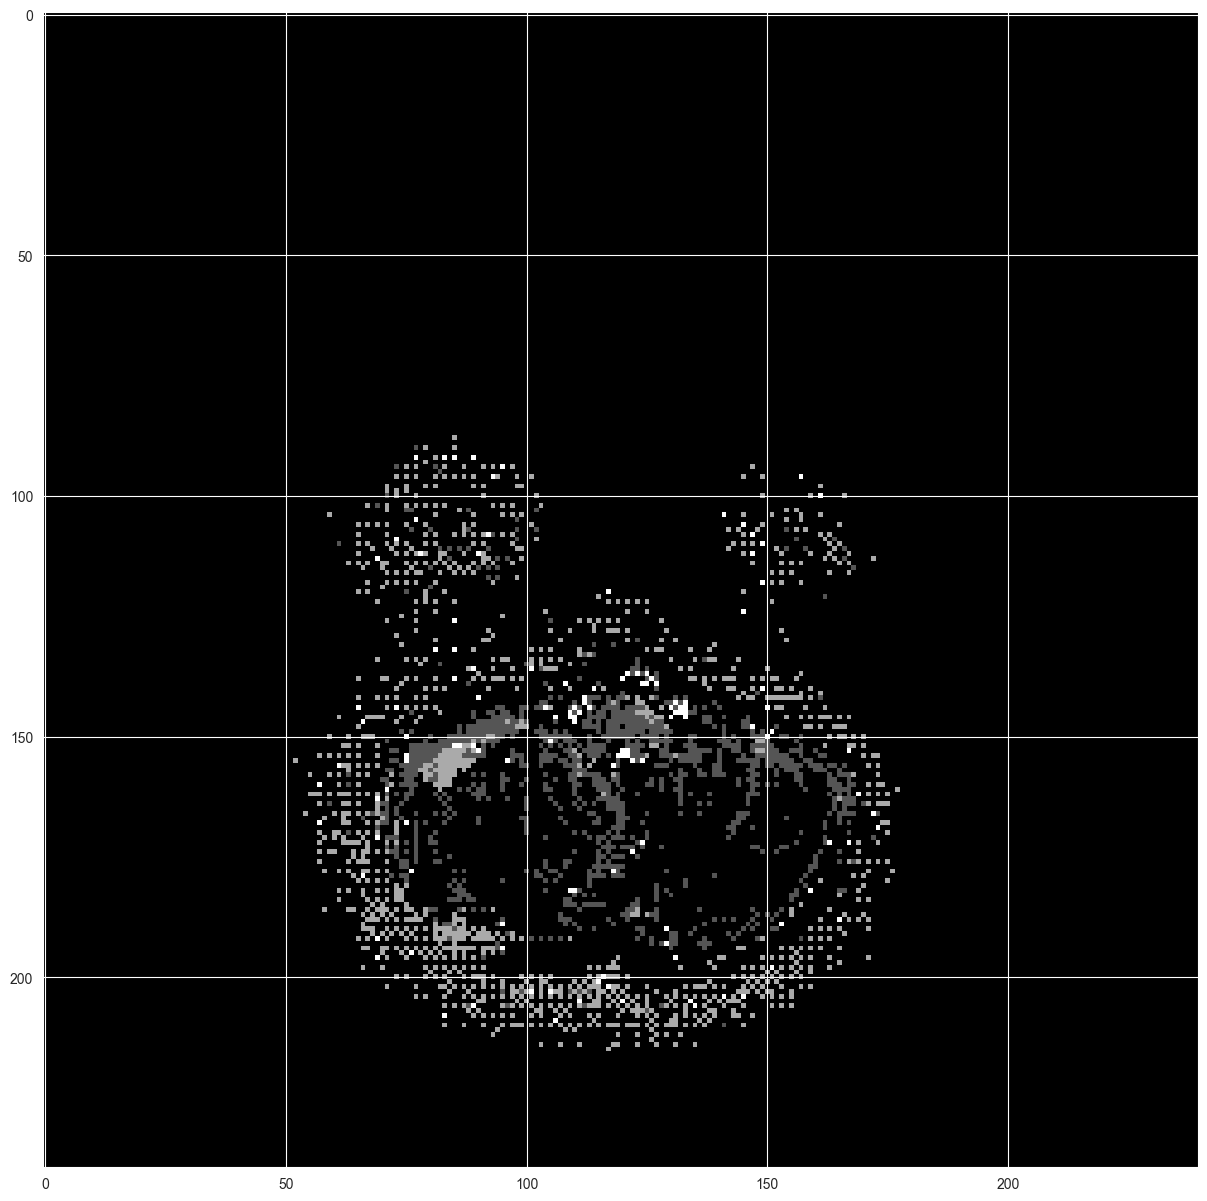

(240, 240, 32)


interactive(children=(ToggleButtons(button_style='info', description='Select Class', options=('Normal', 'Necro…

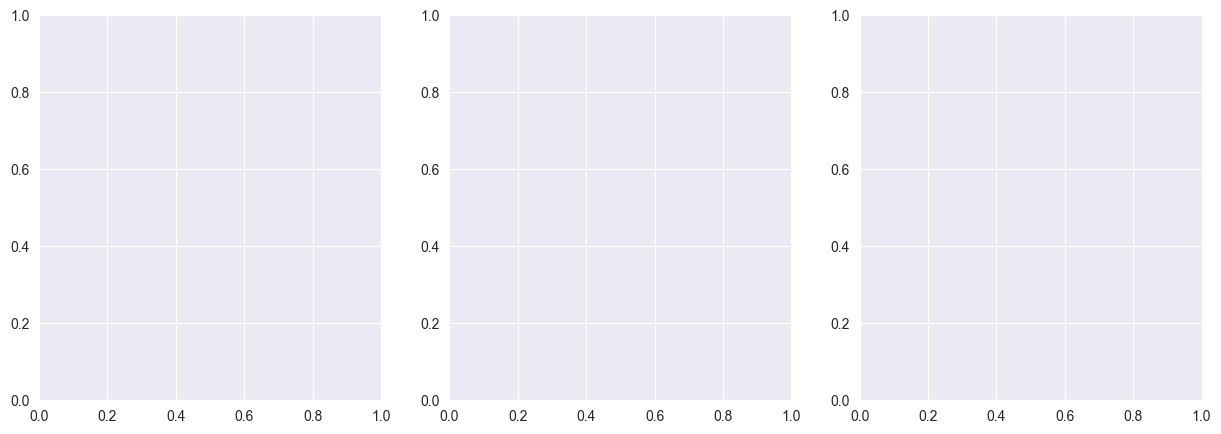

In [31]:
BraTS_dataset.shuffle = False
train_idx = BraTS_dataset.trainNames.index(train_visualization)
# print(val_visualization)
# val_idx = BraTS_dataset.valNames.index(val_visualization)
BraTS_dataset.trainMode()
sample_train, _ = BraTS_dataset.__getitem__(train_idx)
BraTS_dataset.valMode()
# sample_val, _ = BraTS_dataset.__getitem__(val_idx)
# val_pred = np.empty(_label.shape)
with torch.no_grad():
    model = model.cpu()
    # print(sample_train.shape)
    sample_train = torch.reshape(torch.transpose(sample_train, 0, 1), (1, 4, 155, 240, 240))
    sample_train = sample_train[:, :, :32, :, :]
    # print(sample_train.shape)
    train_pred = model(sample_train).argmax(1)
    del sample_train
    # val_pred = model(sample_val).argmax(1)
    # del sample_val
# train_pred = torch.zeros(1, 112, 240, 240)
t_pred = train_pred.detach().numpy().T
# print(t_pred.shape)
# t_pred = np.transpose(train_pred, (2, 1, 0))
t_pred = t_pred[:, :, :, 0]
print(t_pred.shape)
plt.figure(figsize=(15, 15))
plt.imshow(t_pred[:, :, 20], cmap="gray")
plt.show()

print(t_pred.shape)

# train_pred = train_pred[0, 10, :, :]
# v_pred = val_pred.detach().numpy().T
# v_pred = np.transpose(val_pred, (2,1,0))
train_pred = np.where(train_pred==3, 4, train_pred)
# print(train_pred.shape)
# val_pred = np.where(val_pred==3, 4, val_pred)
interactive(visualize_img_training, seg_class=select_class, layer=select_layer, mode=select_mode)


In [32]:
import gc
gc.collect()

3451

In [33]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3080'

In [34]:
with torch.no_grad():
    torch.cuda.empty_cache()

*** Training Epoch 1 ***


  0%|                                                                                          | 0/997 [00:00<?, ?it/s]

(1, 155, 4, 240, 240)
IMAGE SHAPE	 (1, 155, 4, 240, 240)
IMAGE SHAPE2	 (1, 4, 160, 240, 240)


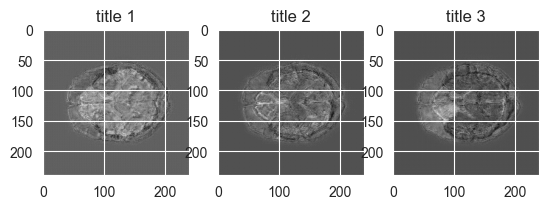

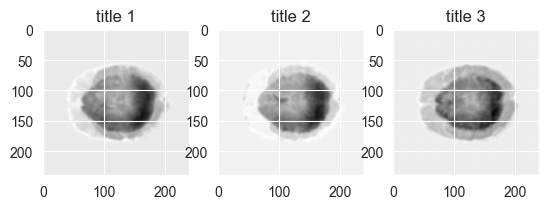

  0%|                                                                                          | 0/997 [00:06<?, ?it/s]

KeyboardInterrupt



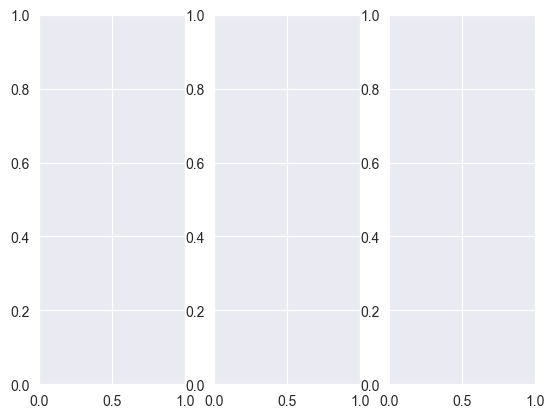

In [35]:
for epoch in range(train_epochs):

    if SHUFFLE: BraTS_dataset.shuffle = True
    if torch.cuda.is_available():
        model = model.cuda()
    
    # Training
    print('*** Training Epoch %d ***'%(epoch+1))
    model.train(True)
    BraTS_dataset.trainMode()
    torch.set_grad_enabled(True)
    total_train_loss = 0
    train_counter = 0
    show_flag = True
    for _img, _label in tqdm(data_loader):
        print(_img.shape)
        gc.collect()
        # print("IN TRAIN")
        # _img = _img.squeeze(0)
        # _label = _label.squeeze(0)
        # print(_img.shape, _label.shape)
        
        # for i in range(0, 155, BATCH_SIZE):
        img = _img
        label = _label
        
        if torch.cuda.is_available():
            img, label = img.cuda(), label.cuda()

        
        print("IMAGE SHAPE\t", img.shape)
        
        
        # print(img.shape, label.shape)
        img = torch.reshape(torch.transpose(img, 0, 1), (1, 4, 155, 240, 240))
        img = torch.cat((torch.zeros(1, 4, 3, 240, 240).cuda(), img, torch.zeros(1, 4, 2, 240, 240).cuda()), 2)
        
        print("IMAGE SHAPE2\t", img.shape)
        
        # print("THE SHAPE after CAT", img.shape)
        img0 = img[:, :, 0:32, :, :]
        img1 = img[:, :, 16:48, :, :]
        img2 = img[:, :, 32:64, :, :]
        img3 = img[:, :, 48:80, :, :]
        img4 = img[:, :, 64:96, :, :]
        img5 = img[:, :, 80:112, :, :]
        img6 = img[:, :, 96:128, :, :]
        img7 = img[:, :, 112:144, :, :]
        img8 = img[:, :, 128:160, :, :]

        
        
        

        label = torch.reshape(torch.transpose(label, 0, 1), (1, 4, 155, 240, 240))
        label = torch.cat((torch.zeros(1, 4, 3, 240, 240).cuda(), label, torch.zeros(1, 4, 2, 240, 240).cuda()), 2)
        
        label0 = label[:, :, 0:32, :, :]
        label1 = label[:, :, 16:48, :, :]
        label2 = label[:, :, 32:64, :, :]
        label3 = label[:, :, 48:80, :, :]
        label4 = label[:, :, 64:96, :, :]
        label5 = label[:, :, 80:112, :, :]
        label6 = label[:, :, 96:128, :, :]
        label7 = label[:, :, 112:144, :, :]
        label8 = label[:, :, 128:160, :, :]
        

        
        # img0
        pred = model(img0)
        # print(label0.shape, pred.shape, img0.shape)

        # plot 

        # print(pred.shape)
        # plt.imshow(pred.detach().numpy()[0, 0, 10, :, :])
        # plt.figure(figsize=(5, 5))
        # plt.imshow(pred.detach().cpu().numpy()[0, 0, 10, :, :], cmap="gray")
        # plt.show()
        
        if show_flag:
            f, axarr = plt.subplots(nrows=1,ncols=3)
            plt.sca(axarr[0]); 
            plt.imshow(pred.detach().cpu().numpy()[0, 0, 10, :, :], cmap="gray"); plt.title('title 1')
            plt.sca(axarr[1]); 
            plt.imshow(pred.detach().cpu().numpy()[0, 0, 15, :, :], cmap="gray"); plt.title('title 2')
            plt.sca(axarr[2]); 
            plt.imshow(pred.detach().cpu().numpy()[0, 0, 25, :, :], cmap="gray"); plt.title('title 3')
            plt.show()

        batch_loss = loss(pred, label0)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        total_train_loss += batch_loss.item()
        # train_counter+=1
        # if train_counter>stop_iter: break
        
        
        
        # img1
        pred = model(img1)
        # print(label1.shape, pred.shape, img1.shape)

        # plot 

        if show_flag:
            f, axarr = plt.subplots(nrows=1,ncols=3)
            plt.sca(axarr[0]); 
            plt.imshow(pred.detach().cpu().numpy()[0, 0, 10, :, :], cmap="gray"); plt.title('title 1')
            plt.sca(axarr[1]); 
            plt.imshow(pred.detach().cpu().numpy()[0, 0, 15, :, :], cmap="gray"); plt.title('title 2')
            plt.sca(axarr[2]); 
            plt.imshow(pred.detach().cpu().numpy()[0, 0, 25, :, :], cmap="gray"); plt.title('title 3')
            plt.show()

        batch_loss = loss(pred, label1)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        total_train_loss += batch_loss.item()
        # train_counter+=1
        # if train_counter>stop_iter: break
        
        #img2
        pred = model(img2)
        # print(label2.shape, pred.shape, img2.shape)

        # plot 

        if show_flag:
            f, axarr = plt.subplots(nrows=1,ncols=3)
            plt.sca(axarr[0]); 
            plt.imshow(pred.detach().cpu().numpy()[0, 0, 10, :, :], cmap="gray"); plt.title('title 1')
            plt.sca(axarr[1]); 
            plt.imshow(pred.detach().cpu().numpy()[0, 0, 15, :, :], cmap="gray"); plt.title('title 2')
            plt.sca(axarr[2]); 
            plt.imshow(pred.detach().cpu().numpy()[0, 0, 25, :, :], cmap="gray"); plt.title('title 3')
            plt.show()
        
        batch_loss = loss(pred, label2)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        total_train_loss += batch_loss.item()
        # train_counter+=1
        # if train_counter>stop_iter: break
        
        #img3
        pred = model(img3)
        # print(label3.shape, pred.shape, img3.shape)

        # plot 

        if show_flag:
            f, axarr = plt.subplots(nrows=1,ncols=3)
            plt.sca(axarr[0]); 
            plt.imshow(pred.detach().cpu().numpy()[0, 0, 10, :, :], cmap="gray"); plt.title('title 1')
            plt.sca(axarr[1]); 
            plt.imshow(pred.detach().cpu().numpy()[0, 0, 15, :, :], cmap="gray"); plt.title('title 2')
            plt.sca(axarr[2]); 
            plt.imshow(pred.detach().cpu().numpy()[0, 0, 25, :, :], cmap="gray"); plt.title('title 3')
            plt.show()

        batch_loss = loss(pred, label3)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        total_train_loss += batch_loss.item()
        
        #img4
        pred = model(img4)
        # print(label4.shape, pred.shape, img4.shape)

        # plot 

        if show_flag:
            f, axarr = plt.subplots(nrows=1,ncols=3)
            plt.sca(axarr[0]); 
            plt.imshow(pred.detach().cpu().numpy()[0, 0, 10, :, :], cmap="gray"); plt.title('title 1')
            plt.sca(axarr[1]); 
            plt.imshow(pred.detach().cpu().numpy()[0, 0, 15, :, :], cmap="gray"); plt.title('title 2')
            plt.sca(axarr[2]); 
            plt.imshow(pred.detach().cpu().numpy()[0, 0, 25, :, :], cmap="gray"); plt.title('title 3')
            plt.show()
        
        batch_loss = loss(pred, label4)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        total_train_loss += batch_loss.item()
        # train_counter+=1
        # if train_counter>stop_iter: break
        
        
        #img5
        pred = model(img5)
        # print(label5.shape, pred.shape, img5.shape)

        # plot 

        if show_flag:
            f, axarr = plt.subplots(nrows=1,ncols=3)
            plt.sca(axarr[0]); 
            plt.imshow(pred.detach().cpu().numpy()[0, 0, 10, :, :], cmap="gray"); plt.title('title 1')
            plt.sca(axarr[1]); 
            plt.imshow(pred.detach().cpu().numpy()[0, 0, 15, :, :], cmap="gray"); plt.title('title 2')
            plt.sca(axarr[2]); 
            plt.imshow(pred.detach().cpu().numpy()[0, 0, 25, :, :], cmap="gray"); plt.title('title 3')
            plt.show()

        batch_loss = loss(pred, label5)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        total_train_loss += batch_loss.item()
        # train_counter+=1
        # if train_counter>stop_iter: break
        
        
        
        #img6
        pred = model(img6)
        # print(label6.shape, pred.shape, img6.shape)

        # plot 

        if show_flag:
            f, axarr = plt.subplots(nrows=1,ncols=3)
            plt.sca(axarr[0]); 
            plt.imshow(pred.detach().cpu().numpy()[0, 0, 10, :, :], cmap="gray"); plt.title('title 1')
            plt.sca(axarr[1]); 
            plt.imshow(pred.detach().cpu().numpy()[0, 0, 15, :, :], cmap="gray"); plt.title('title 2')
            plt.sca(axarr[2]); 
            plt.imshow(pred.detach().cpu().numpy()[0, 0, 25, :, :], cmap="gray"); plt.title('title 3')
            plt.show()

        batch_loss = loss(pred, label6)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        total_train_loss += batch_loss.item()
        # train_counter+=1
        # if train_counter>stop_iter: break
        
        #img2
        pred = model(img7)
        # print(label7.shape, pred.shape, img2.shape)

        # plot 

        if show_flag:
            f, axarr = plt.subplots(nrows=1,ncols=3)
            plt.sca(axarr[0]); 
            plt.imshow(pred.detach().cpu().numpy()[0, 0, 10, :, :], cmap="gray"); plt.title('title 1')
            plt.sca(axarr[1]); 
            plt.imshow(pred.detach().cpu().numpy()[0, 0, 15, :, :], cmap="gray"); plt.title('title 2')
            plt.sca(axarr[2]); 
            plt.imshow(pred.detach().cpu().numpy()[0, 0, 25, :, :], cmap="gray"); plt.title('title 3')
            plt.show()

        batch_loss = loss(pred, label7)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        total_train_loss += batch_loss.item()
        # train_counter+=1
        # if train_counter>stop_iter: break
        
        #img8
        pred = model(img8)
        # print(label7.shape, pred.shape, img2.shape)

        # plot 

        if show_flag:
            f, axarr = plt.subplots(nrows=1,ncols=3)
            plt.sca(axarr[0]); 
            plt.imshow(pred.detach().cpu().numpy()[0, 0, 10, :, :], cmap="gray"); plt.title('title 1')
            plt.sca(axarr[1]); 
            plt.imshow(pred.detach().cpu().numpy()[0, 0, 15, :, :], cmap="gray"); plt.title('title 2')
            plt.sca(axarr[2]); 
            plt.imshow(pred.detach().cpu().numpy()[0, 0, 25, :, :], cmap="gray"); plt.title('title 3')
            plt.show()
        
        show_flag = False
        
        batch_loss = loss(pred, label8)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        total_train_loss += batch_loss.item()
        # train_counter+=1
        # if train_counter>stop_iter: break
        
        train_counter+=1
        if train_counter>stop_iter: break
        
    # batch_per_img = 155//BATCH_SIZE if 155%BATCH_SIZE==0 else (155//BATCH_SIZE)+1
    batch_per_img = 1
    final_train_loss = total_train_loss / (1 * batch_per_img)
    train_loss_history.append(final_train_loss)
    print('Epoch: %d  Train Loss: %.6f \n' %(epoch+1, final_train_loss))

    # Validation
    print('*** Validation Epoch %d ***'%(epoch+1))
    model.eval()
    BraTS_dataset.valMode()
    torch.set_grad_enabled(False)
    total_val_loss = 0
    val_counter=0
    for _img, _label in tqdm(data_loader):
        # print("IN VAL")
        # _img = _img.squeeze(0)
        # _label = _label.squeeze(0)
        # for i in range(0, 155, BATCH_SIZE):
        img = _img
        label = _label
        
        # print("THE SHAPE AFTER CAT", img.shape)
        
        if torch.cuda.is_available():
            img, label = img.cuda(), label.cuda()
                
        print("IMAGE SHAPE\t", img.shape)
        img = torch.reshape(torch.transpose(img, 0, 1), (1, 4, 155, 240, 240))
        img = torch.cat((torch.zeros(1, 4, 3, 240, 240).cuda(), img, torch.zeros(1, 4, 2, 240, 240).cuda()), 2)
        print("IMAGE SHAPE2\t", img.shape)
        
        img0 = img[:, :, 0:32, :, :]
        img1 = img[:, :, 16:48, :, :]
        img2 = img[:, :, 32:64, :, :]
        img3 = img[:, :, 48:80, :, :]
        img4 = img[:, :, 64:96, :, :]
        img5 = img[:, :, 80:112, :, :]
        img6 = img[:, :, 96:128, :, :]
        img7 = img[:, :, 112:144, :, :]
        img8 = img[:, :, 128:160, :, :]
        
        
        

        label = torch.reshape(torch.transpose(label, 0, 1), (1, 4, 155, 240, 240))
        label = torch.cat((torch.zeros(1, 4, 3, 240, 240).cuda(), label, torch.zeros(1, 4, 2, 240, 240).cuda()), 2)
        
        label0 = label[:, :, 0:32, :, :]
        label1 = label[:, :, 16:48, :, :]
        label2 = label[:, :, 32:64, :, :]
        label3 = label[:, :, 48:80, :, :]
        label4 = label[:, :, 64:96, :, :]
        label5 = label[:, :, 80:112, :, :]
        label6 = label[:, :, 96:128, :, :]
        label7 = label[:, :, 112:144, :, :]
        label8 = label[:, :, 128:160, :, :]
        
        pred = model(img1)
        batch_loss = loss(pred, label1)
        total_val_loss += batch_loss.item()
        
        
        pred = model(img2)
        batch_loss = loss(pred, label2)
        total_val_loss += batch_loss.item()
        
        pred = model(img3)
        batch_loss = loss(pred, label3)
        total_val_loss += batch_loss.item()
        
        pred = model(img4)
        batch_loss = loss(pred, label4)
        total_val_loss += batch_loss.item()
        
        pred = model(img5)
        batch_loss = loss(pred, label5)
        total_val_loss += batch_loss.item()
        pred = model(img6)
        batch_loss = loss(pred, label6)
        total_val_loss += batch_loss.item()
        pred = model(img7)
        batch_loss = loss(pred, label7)
        total_val_loss += batch_loss.item()
        pred = model(img8)
        batch_loss = loss(pred, label8)
        total_val_loss += batch_loss.item()
        
        val_counter+=1
        if val_counter>stop_iter: break


    # batch_per_img = 155//BATCH_SIZE if 155%BATCH_SIZE==0 else (155//BATCH_SIZE)+1
    batch_per_img = 1
    final_val_loss = total_val_loss / (1 * batch_per_img)
    val_loss_history.append(final_val_loss)
    print('Epoch: %d  Validation Loss: %.6f \n\n' %(epoch+1, final_val_loss))
    # Saving the best Model
    if total_val_loss <= best_loss:
        torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'train_loss': total_train_loss,
          'val_loss': total_val_loss,
        }, './best_3d.pth')

    # Early Stopping
    early_stopping(total_train_loss, total_val_loss)
    if early_stopping.early_stop:
        print("Early Stopping at Epoch: ", epoch)
        break

    # Learning rate scheduling
    if early_stopping.counter==3:
        print("Reducing learning rate.")
        for param_group in optimizer.param_groups:
            param_group["lr"] *= 0.5
        lr_tracker.append(epoch)

    # Plotting Train/Validation Loss
    plotter(train_loss_history, val_loss_history, lr_tracker, 'loss', 'Train / Val Loss')

    # Visualizing Model Predictions
    

    
    # BraTS_dataset.shuffle = False
    # train_idx = BraTS_dataset.trainNames.index(train_visualization)
    # val_idx = BraTS_dataset.valNames.index(val_visualization)
    # BraTS_dataset.trainMode()
    # sample_train, _ = BraTS_dataset.__getitem__(train_idx)
    # BraTS_dataset.valMode()
    # sample_val, _ = BraTS_dataset.__getitem__(val_idx)
    # val_pred = np.empty(_label.shape)
    # with torch.no_grad():
    #     model = model.cpu()
    #     train_pred = model(sample_train).argmax(1)
    #     del sample_train
    #     val_pred = model(sample_val).argmax(1)
    #     del sample_val
    # train_pred = train_pred.detach().numpy().T
    # train_pred = np.transpose(train_pred, (2,1,0))
    # val_pred = val_pred.detach().numpy().T
    # val_pred = np.transpose(val_pred, (2,1,0))
    # train_pred = np.where(train_pred==3, 4, train_pred)
    # val_pred = np.where(val_pred==3, 4, val_pred)
    # interactive(visualize_img_training, seg_class=select_class, layer=select_layer, mode=select_mode)


In [ ]:
# interactive(visualize_img_training, seg_class=select_class, layer=select_layer, mode=select_mode)